In [1]:

!pip install -q kaggle

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [2]:
!kaggle datasets download tusharpadhy/deepfake-dataset

Dataset URL: https://www.kaggle.com/datasets/tusharpadhy/deepfake-dataset
License(s): CC0-1.0
100% 5.42G/5.42G [04:09<00:00, 23.1MB/s]
100% 5.42G/5.42G [04:09<00:00, 23.3MB/s]


In [3]:
!unzip /content/deepfake-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid/Real/real_5499.jpg  
  inflating: valid/Real/real_55.jpg  
  inflating: valid/Real/real_550.jpg  
  inflating: valid/Real/real_5500.jpg  
  inflating: valid/Real/real_5501.jpg  
  inflating: valid/Real/real_5502.jpg  
  inflating: valid/Real/real_5503.jpg  
  inflating: valid/Real/real_5504.jpg  
  inflating: valid/Real/real_5505.jpg  
  inflating: valid/Real/real_5506.jpg  
  inflating: valid/Real/real_5507.jpg  
  inflating: valid/Real/real_5508.jpg  
  inflating: valid/Real/real_5509.jpg  
  inflating: valid/Real/real_551.jpg  
  inflating: valid/Real/real_5510.jpg  
  inflating: valid/Real/real_5511.jpg  
  inflating: valid/Real/real_5512.jpg  
  inflating: valid/Real/real_5513.jpg  
  inflating: valid/Real/real_5514.jpg  
  inflating: valid/Real/real_5515.jpg  
  inflating: valid/Real/real_5516.jpg  
  inflating: valid/Real/real_5517.jpg  
  inflating: valid/Real/real_5518.jpg  
  inflating: valid/Real/real_5519

In [4]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [5]:
!pip install timm

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import time, copy
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import timm

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset for quick example.
image_dataset = datasets.ImageFolder(root='/content/train', transform=transform)
batch_size = 256
data_loader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True)

# Display one sample image and its label.
image, label = image_dataset[0]
print("Example Image Shape:", image.shape)
print("Example Label:", label)

# Define transforms for training and validation.
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # adjust to 299 if desired
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dir = '/content/train'
val_dir   = '/content/valid'

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transforms)

print("Classes found:", train_dataset.classes)

Example Image Shape: torch.Size([3, 224, 224])
Example Label: 0
Classes found: ['Fake', 'Real']


In [11]:
model = timm.create_model('xception41', pretrained=True)

# Freeze all parameters.
for param in model.parameters():
    param.requires_grad = False

print("Original classifier:", model.get_classifier())
model.reset_classifier(num_classes=1)
print("Modified classifier:", model.get_classifier())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

Original classifier: Linear(in_features=2048, out_features=1000, bias=True)
Modified classifier: Linear(in_features=2048, out_features=1, bias=True)
XceptionAligned(
  (stem): Sequential(
    (0): ConvNormAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (1): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
  )
  (blocks): Sequential(
    (0): XceptionModule(
      (shortcut): ConvNormAct(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (bn): BatchNormAct2d(
          128, eps=0.001, momentum=0

In [13]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [14]:
criterion = nn.BCEWithLogitsLoss()

# Initially, optimize only the classifier parameters
optimizer = optim.Adam(model.get_classifier().parameters(), lr=1e-4)

def train_model(model, criterion, optimizer, dataloaders, num_epochs=10, device='cuda'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = dataloaders['train']
            else:
                model.eval()
                loader = dataloaders['val']

            running_loss = 0.0
            running_corrects = 0
            total = 0

            for inputs, labels in loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = (torch.sigmoid(outputs) > 0.5).float()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total += inputs.size(0)

            epoch_loss = running_loss / total
            epoch_acc = running_corrects.double() / total

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val loss: {best_loss:.4f}')

    model.load_state_dict(best_model_wts)
    history = {'train_loss': train_losses, 'val_loss': val_losses,
               'train_acc': train_accs, 'val_acc': val_accs}
    return model, history

dataloaders = {'train': train_loader, 'val': val_loader}

In [15]:
# Initial Training
num_epochs = 5  # Adjust as needed.
model, history = train_model(model, criterion, optimizer, dataloaders,
                             num_epochs=num_epochs, device=device)

Epoch 1/5
----------
Train Loss: 0.6453 Acc: 0.6288
Val Loss: 0.6434 Acc: 0.6279

Epoch 2/5
----------
Train Loss: 0.6193 Acc: 0.6576
Val Loss: 0.6365 Acc: 0.6389

Epoch 3/5
----------
Train Loss: 0.6096 Acc: 0.6674
Val Loss: 0.6271 Acc: 0.6497

Epoch 4/5
----------
Train Loss: 0.6031 Acc: 0.6725
Val Loss: 0.6226 Acc: 0.6546

Epoch 5/5
----------
Train Loss: 0.5994 Acc: 0.6763
Val Loss: 0.6168 Acc: 0.6607

Training complete in 22m 57s
Best val loss: 0.6168


In [16]:
# Unfreeze the classifier
for name, param in model.named_parameters():
    if "fc" in name or "classifier" in name:
        param.requires_grad = True
    elif "blocks" in name:
        try:
            block_num = int(name.split('.')[1])
            if block_num >= 7:
                param.requires_grad = True
            else:
                param.requires_grad = False
        except Exception:
            param.requires_grad = False
    else:
        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
num_epochs_ft = 5
model, history_ft = train_model(model, criterion, optimizer_ft, dataloaders,
                                num_epochs=num_epochs_ft, device=device)

history['train_loss'].extend(history_ft['train_loss'])
history['val_loss'].extend(history_ft['val_loss'])
history['train_acc'].extend(history_ft['train_acc'])
history['val_acc'].extend(history_ft['val_acc'])

Epoch 1/5
----------
Train Loss: 0.3990 Acc: 0.8087
Val Loss: 0.2963 Acc: 0.8778

Epoch 2/5
----------
Train Loss: 0.2474 Acc: 0.8918
Val Loss: 0.2274 Acc: 0.9092

Epoch 3/5
----------
Train Loss: 0.2004 Acc: 0.9148
Val Loss: 0.1852 Acc: 0.9277

Epoch 4/5
----------
Train Loss: 0.1713 Acc: 0.9271
Val Loss: 0.1567 Acc: 0.9384

Epoch 5/5
----------
Train Loss: 0.1542 Acc: 0.9357
Val Loss: 0.1415 Acc: 0.9444

Training complete in 30m 29s
Best val loss: 0.1415


In [17]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = (torch.sigmoid(outputs) > 0.5).int()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[27575  2066]
 [ 1236 28551]]

Classification Report:
              precision    recall  f1-score   support

        Fake       0.96      0.93      0.94     29641
        Real       0.93      0.96      0.95     29787

    accuracy                           0.94     59428
   macro avg       0.94      0.94      0.94     59428
weighted avg       0.94      0.94      0.94     59428



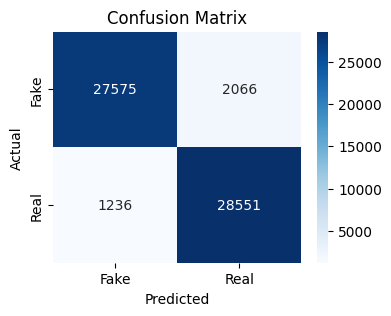

In [18]:
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

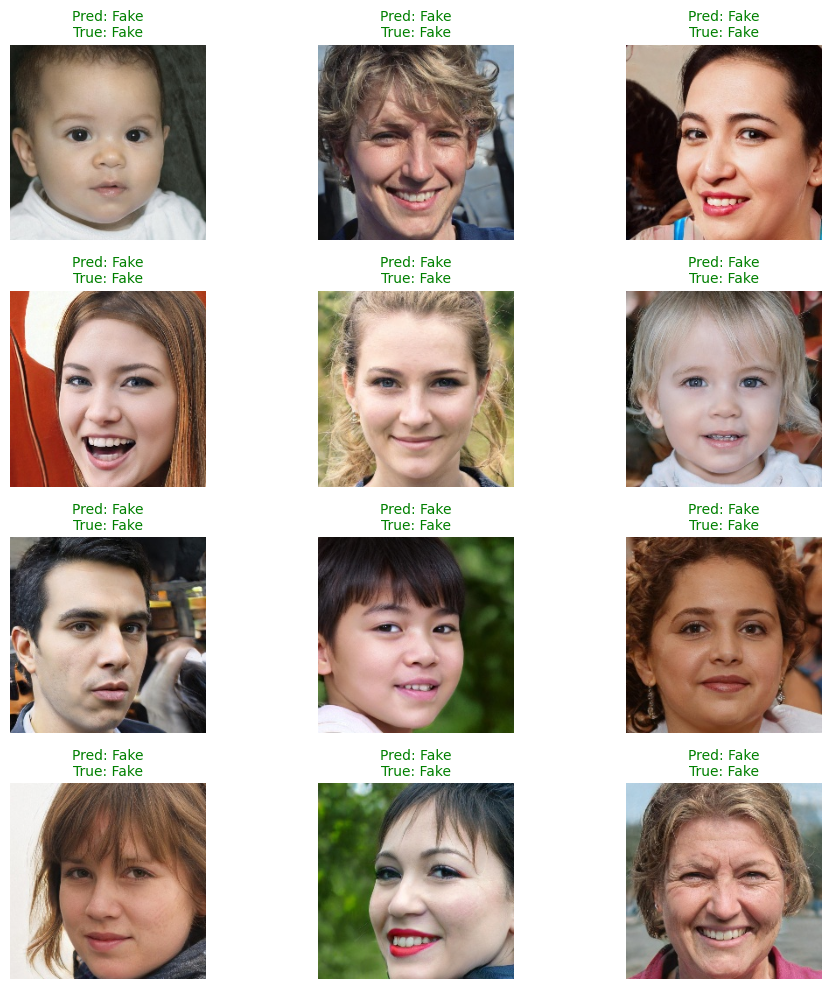

In [21]:
# Visualizing Some Predictions
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

inputs, labels = next(iter(val_loader))
inputs = inputs.to(device)
outputs = model(inputs)
preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy().flatten()
labels = labels.numpy()

plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    pred_label = train_dataset.classes[preds[i]]
    true_label = train_dataset.classes[labels[i]]
    color = "green" if pred_label == true_label else "red"
    imshow(inputs[i], title=f"Pred: {pred_label}\nTrue: {true_label}")
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=10)
plt.tight_layout()
plt.show()

In [23]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

accuracy = accuracy_score(all_labels, all_preds)
sensitivity = recall_score(all_labels, all_preds)  # Sensitivity is same as recall
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_preds)

print(f"Accuracy: {accuracy*100:.1f}%")
print(f"Sensitivity (Recall): {recall*100:.1f}%")
print(f"Recall: {recall*100:.1f}%")
print(f"F1 Score: {f1*100:.1f}%")
print(f"AUC: {auc*100:.1f}%")

Accuracy: 94.4%
Sensitivity (Recall): 95.9%
Recall: 95.9%
F1 Score: 94.5%
AUC: 94.4%


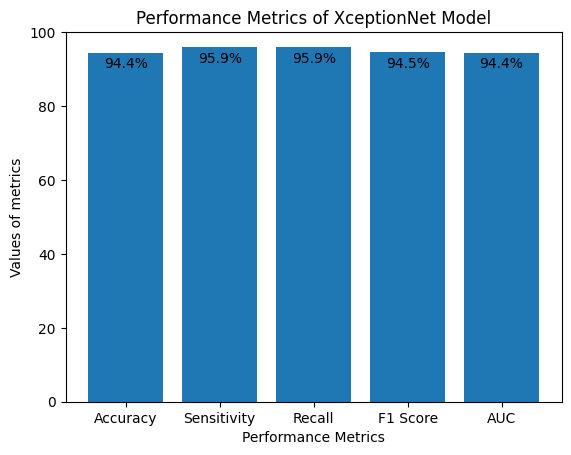

In [27]:
metrics_names = ['Accuracy', 'Sensitivity', 'Recall', 'F1 Score', 'AUC']
metrics_values = [accuracy*100, recall*100, recall*100, f1*100, auc*100]

fig, ax = plt.subplots()
bars = ax.bar(metrics_names, metrics_values)

# Add data labels
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval - 5, f'{yval:.1f}%', ha='center', va='bottom', color='black', fontsize=10)

# Plot formatting
plt.ylim(0, 100)
plt.ylabel('Values of metrics')
plt.xlabel('Performance Metrics')
plt.title('Performance Metrics of XceptionNet Model')
plt.show()